### necessary libraries: resemblyzer, pyannote

In [44]:
from resemblyzer import preprocess_wav, VoiceEncoder
from demo_utils import *
from itertools import groupby
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False 
plt.rcParams["font.family"] = 'NanumGothic'

### utterance embedding: umap projection
- compare speech utterances between iptv speakers
- metric: how similar their sounds

In [4]:
def plot_projection_adv(embeds, speakers, ax=None, colors=None, markers=None, legend=True, 
                        title="", **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 10))
        
    reducer = UMAP(n_neighbors=30, min_dist=0.2, **kwargs) # 2D projections
    projs = reducer.fit_transform(embeds)  # projs.shape
    speakers = np.array(speakers)
    
    for i, speaker in enumerate(np.unique(speakers)):
        speaker_projs = projs[speakers == speaker]
        marker = "o" if markers is None else markers[i]
        label = speaker if legend else None
        ax.scatter(*speaker_projs.T, cmap=plt.cm.Blues, 
                    marker=marker, label=label, alpha=0.7)

    if legend:
        ax.legend(title="Speakers", ncol=2, loc="upper right")
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    
    return projs

In [5]:
wav_fpaths = list(Path("audio_data", "iptv_uttr", "sample").glob("**/*.wav"))
speakers = list(map(lambda wav_fpath: wav_fpath.parent.stem, wav_fpaths))
wavs = np.array(list(map(preprocess_wav, tqdm(wav_fpaths, "Preprocessing wavs", len(wav_fpaths), position=0))))
speaker_wavs = {speaker: wavs[list(indices)] for speaker, indices in 
                groupby(range(len(wavs)), lambda i: speakers[i])}

Preprocessing wavs: 100%|██████████| 1580/1580 [00:11<00:00, 136.82it/s]


In [45]:
pd.DataFrame(utterance_embeds).to_csv('sample.csv', index=False)

In [61]:
wavs = [preprocess_wav(wav_fpath) for wav_fpath in \
        tqdm(wav_fpaths, "Preprocessing wavs", len(wav_fpaths), unit=" utterances")]

Preprocessing wavs: 100%|██████████| 1580/1580 [00:11<00:00, 133.64 utterances/s]


In [62]:
embeds = np.array([encoder.embed_utterance(wav) for wav in wavs]) 
names = np.array([fpath.stem for fpath in wav_fpaths]) 

In [65]:
embeds_total = np.array([encoder.embed_utterance(wav[:len(wavs)]) \
                    for wav in wavs])

In [67]:
embeds_total.shape

(1580, 256)

In [68]:
test_path = Path("audio_data", "iptv_uttr", "test", "record_163357.pcm.wav") 
test_wav = preprocess_wav(test_path)
test_embed = encoder.embed_utterance(test_wav)

spk_sim_matrix = np.inner(embeds_total, test_embed)

In [71]:
labels = [i for i in wavs]
#stats = dict(zip(labels, spk_sim_matrix))

In [ ]:

max(stats, key=stats.get)
plt.bar(list(stats.keys()), stats.values(), color='g')
plt.show()

In [54]:

# Take 6 real embeddings at random, and leave the 6 others for testing
gt_indices = np.random.choice(*np.where(speakers == "real"), 6, replace=False) 
mask = np.zeros(len(embeds), dtype=np.bool)
mask[gt_indices] = True
gt_embeds = embeds[mask]
gt_names = names[mask]
gt_speakers = speakers[mask]
embeds, speakers, names = embeds[~mask], speakers[~mask], names[~mask]


## Compare all embeddings against the ground truth embeddings, and compute the average similarities.
scores = (gt_embeds @ embeds.T).mean(axis=0)

# Order the scores by decreasing order
sort = np.argsort(scores)[::-1]
scores, names, speakers = scores[sort], names[sort], speakers[sort]


## Plot the scores
fig, _ = plt.subplots(figsize=(6, 6))
indices = np.arange(len(scores))
plt.axhline(0.84, ls="dashed", label="Prediction threshold", c="black")
plt.bar(indices[speakers == "real"], scores[speakers == "real"], color="green", label="Real")
plt.bar(indices[speakers == "fake"], scores[speakers == "fake"], color="red", label="Fake")
plt.legend()
plt.xticks(indices, names, rotation="vertical", fontsize=8)
plt.xlabel("Youtube video IDs")
plt.ylim(0.7, 1)
plt.ylabel("Similarity to ground truth")
fig.subplots_adjust(bottom=0.25)
plt.show()

(256,)

In [10]:
for key, value in sorted(speaker_wavs.items()):
    print(key, len(value))

김나영 152
김윤재 152
김지현 161
김진주 151
김훈 183
류성균 157
문성재 140
박민선 151
박상훈 147
박지웅 186


In [6]:
encoder = VoiceEncoder()
utterance_embeds = np.array(list(map(encoder.embed_utterance, wavs)))

Loaded the voice encoder model on cuda in 1.33 seconds.


In [34]:
utterance_embeds = np.array(list(map(encoder.embed_utterance, wavs)))

In [36]:
utterance_embeds.shape

(1580, 256)

In [7]:
encoder

VoiceEncoder(
  (lstm): LSTM(40, 256, num_layers=3, batch_first=True)
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (relu): ReLU()
)

In [8]:
print(utterance_embeds)
print(utterance_embeds.shape)

[[0.1429932  0.         0.08203338 ... 0.         0.02254576 0.        ]
 [0.0824085  0.         0.09048542 ... 0.         0.         0.        ]
 [0.10434511 0.03245925 0.01089699 ... 0.         0.         0.        ]
 ...
 [0.11729597 0.02526935 0.00973654 ... 0.         0.0406806  0.        ]
 [0.08629341 0.         0.07767767 ... 0.         0.         0.        ]
 [0.04871748 0.         0.03460011 ... 0.         0.         0.        ]]
(1580, 256)


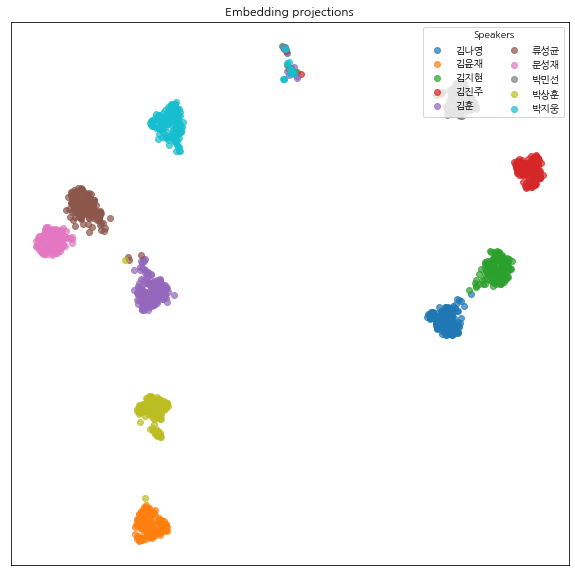

In [9]:
## Project the embeddings in 2D space
plot_projection_adv(utterance_embeds, speakers, title="Embedding projections")
plt.show()

### speaker embedding: similarity computation

In [11]:
speaker_wavs.get('김윤재')[:3]

array([array([ 0.00051591,  0.00046901,  0.0001407 , ..., -0.0001876 ,
        0.00023451,  0.00042211], dtype=float32),
       array([-0.00054932,  0.00015259, -0.00021362, ...,  0.00064087,
        0.00073242,  0.00033569], dtype=float32),
       array([ 0.0000000e+00,  0.0000000e+00, -3.0885127e-05, ...,
       -1.1118646e-03, -8.3389843e-04, -1.1118646e-03], dtype=float32)],
      dtype=object)

In [13]:
# wavs[0] : 인간극장 정동원편 틀어주세요
embeds_a = np.array([encoder.embed_utterance(wavs[0]) for wavs in speaker_wavs.values()])

# wavs[1] : 우아한 모녀 실행해줘 
embeds_b = np.array([encoder.embed_utterance(wavs[1]) for wavs in speaker_wavs.values()])

print("Shape of embeddings: %s" % str(embeds_a.shape))

Shape of embeddings: (10, 256)


In [14]:
# similarity matrix: cosine distance, L2
utt_sim_matrix = np.inner(embeds_a, embeds_b)
utt_sim_matrix2 = np.zeros((len(embeds_a), len(embeds_b))) # long, detailed version

for i in range(len(embeds_a)):
    for j in range(len(embeds_b)):
        utt_sim_matrix2[i, j] = embeds_a[i] @ embeds_b[j]  # np.matmul(embeds_a[i], embeds_b[i])  

assert np.allclose(utt_sim_matrix, utt_sim_matrix2) 

- Similarity between two speaker embeddings
    * Divide the utterances of each speaker in groups of identical size
    * embed each group as a speaker embedding

In [15]:
spk_embeds_a = np.array([encoder.embed_speaker(wavs[:len(wavs) // 2]) \
                         for wavs in speaker_wavs.values()])
spk_embeds_b = np.array([encoder.embed_speaker(wavs[len(wavs) // 2:]) \
                         for wavs in speaker_wavs.values()])

In [16]:
spk_sim_matrix = np.inner(spk_embeds_a, spk_embeds_b)
labels_a = ["%s-A" % i for i in speaker_wavs.keys()]
labels_b = ["%s-B" % i for i in speaker_wavs.keys()]
mask = np.eye(len(utt_sim_matrix), dtype=np.bool)

In [17]:
labels_a = ["%s-A" % i for i in speaker_wavs.keys()]
labels_b = ["%s-B" % i for i in speaker_wavs.keys()]
mask = np.eye(len(utt_sim_matrix2), dtype=np.bool)

<AxesSubplot:title={'center':'Cross-similarity between utterances\n(speaker_id-utterance_group)'}>

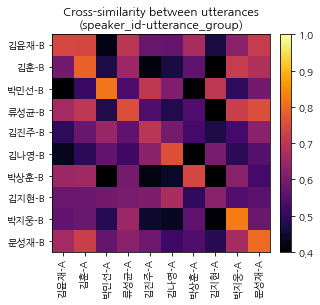

In [18]:
plot_similarity_matrix(utt_sim_matrix2, labels_a, labels_b, 
                       title="Cross-similarity between utterances\n(speaker_id-utterance_group)")

<AxesSubplot:title={'center':'Normalized histogram of similarity\nvalues between utterances'}>

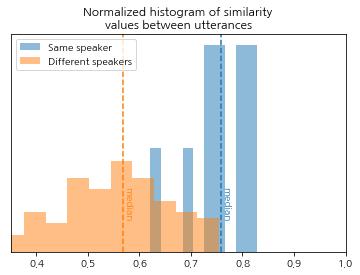

In [19]:
plot_histograms((utt_sim_matrix2[mask], utt_sim_matrix2[np.logical_not(mask)]), 
                names=["Same speaker", "Different speakers"], 
                title="Normalized histogram of similarity\nvalues between utterances")

In [22]:
test_path = Path("audio_data", "iptv_uttr", "test", "record_163357.pcm.wav") 
test_wav = preprocess_wav(test_path)
test_embed = encoder.embed_utterance(test_wav)

In [26]:
spk_embeds_total = np.array([encoder.embed_speaker(wavs[:len(wavs)]) \
                         for wavs in speaker_wavs.values()])

In [30]:
spk_sim_matrix = np.inner(spk_embeds_total, test_embed)
spk_sim_matrix

array([0.6364689 , 0.6043494 , 0.6463269 , 0.5718777 , 0.688427  ,
       0.8805681 , 0.65756977, 0.7757151 , 0.56808317, 0.62214327],
      dtype=float32)

In [31]:
labels = [i for i in speaker_wavs.keys()]

In [32]:
stats = dict(zip(labels, spk_sim_matrix))
max(stats, key=stats.get)

'김나영'

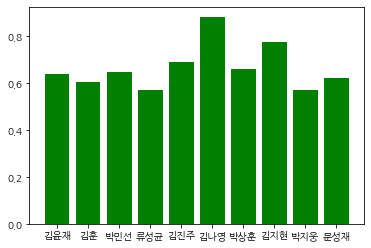

In [33]:
plt.bar(list(stats.keys()), stats.values(), color='g')
plt.show()

In [ ]:
### 
wav_fpaths = list(Path("audio_data", "iptv_uttr", "sample").glob("**/*.wav"))
speakers = list(map(lambda wav_fpath: wav_fpath.parent.stem, wav_fpaths))
wavs = np.array(list(map(preprocess_wav, tqdm(wav_fpaths, "Preprocessing wavs", len(wav_fpaths), position=0))))
speaker_wavs = {speaker: wavs[list(indices)] for speaker, indices in 
                groupby(range(len(wavs)), lambda i: speakers[i])}

In [ ]:
data_dir = Path("audio_data", "librispeech_train-clean-100")
wav_fpaths = list(data_dir.glob("*.flac"))
speakers = [fpath.stem.split("-")[0] for fpath in wav_fpaths]
wavs = [preprocess_wav(wav_fpath) for wav_fpath in \
        tqdm(wav_fpaths, "Preprocessing wavs", len(wav_fpaths), unit=" utterances")]